In [1]:
import jax
import importlib
from jcm import model as mod
importlib.reload(mod)

def test_speedy_model(time_step=120,
                      save_interval=1,
                      total_time=1,
                      layers=7):
    from dinosaur import primitive_equations_states

    model = mod.SpeedyModel(
        time_step=time_step,
        save_interval=save_interval,
        total_time=total_time,
        layers=layers,
    )

    state = model.get_initial_state()
    q_perturbation = primitive_equations_states.gaussian_scalar(model.coords, model.physics_specs)
    q_perturbation = model.coords.horizontal.to_modal(
        1e-3 * model.coords.horizontal.to_nodal(q_perturbation)
    )
    state.tracers = {'specific_humidity': q_perturbation}

    final_state, predictions = model.unroll(state)

    return final_state, predictions, model

In [2]:
jax.config.update('jax_disable_jit', True)
jax.config.update("jax_debug_infs", True)
jax.config.update("jax_debug_nans", True)
final_state, predictions, model = test_speedy_model()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


u:  0.0 0.0
v:  0.0 0.0
t:  288.0 288.0
q:  5.454564e-15 0.99793124
testing 1
testing 2
u:  -0.037633583 0.037218194
v:  -0.035442073 0.044574305
t:  287.7313 292.13617
q:  5.454564e-15 4.3243303
testing 1
testing 2
u:  -0.08043478 0.08255639
v:  -0.06985992 0.11023155
t:  287.54602 296.1441
q:  7.95265e-12 6.198012
testing 1
testing 2
u:  -0.14654163 0.17059277
v:  -0.12860651 0.22206786
t:  287.18552 299.26257
q:  3.735184e-11 7.7491035
testing 1
testing 2
u:  -0.22415973 0.2676364
v:  -0.18829666 0.34901923
t:  286.7993 302.3222
q:  2.3982144e-12 8.876441
testing 1
testing 2
u:  -0.27119517 0.36167514
v:  -0.2222499 0.45040193
t:  286.34644 303.29745
q:  7.778296e-12 9.056308
testing 1
testing 2
u:  -0.2656602 0.43715474
v:  -0.21600005 0.5298553
t:  285.9577 305.0158
q:  7.0365675e-12 9.718207
testing 1
testing 2
u:  -0.26878494 0.50540334
v:  -0.20053309 0.59969574
t:  285.51862 304.6896
q:  1.2048399e-11 9.622912
testing 1
testing 2
u:  -0.23967446 0.5666612
v:  -0.22001712 0.651

putting temperature variation in a to_modal(to_nodal) added 20 seconds to a 100 second run?

why is dynamics state to physics state called ... 36 times in a timestep=120 1 day run? shouldn't it be... 12 times?

In [4]:
# # read icltop.npy into numpy array
# import numpy as np
# import matplotlib.pyplot as plt
# icltop = np.load('icltop.npy')
# plt.imshow(icltop)
# plt.show()

In [5]:
# jax.config.update('jax_disable_jit', False)
# jax.config.update("jax_debug_infs", False)
# jax.config.update("jax_debug_nans", False)
# final_state, predictions, model = test_speedy_model()

In [3]:
from dinosaur import primitive_equations as pe

coords = model.coords

diagnostic_final_state = pe.compute_diagnostic_state(final_state, coords)
vertical_velocity = pe.compute_vertical_velocity(final_state, coords)

print('Computed nodal quantities:\n' + '\n'.join(diagnostic_final_state.__dataclass_fields__.keys()))

Computed nodal quantities:
vorticity
divergence
temperature_variation
cos_lat_u
sigma_dot_explicit
sigma_dot_full
cos_lat_grad_log_sp
u_dot_grad_log_sp
tracers


In [4]:
from dinosaur import spherical_harmonic as sh
from dinosaur.scales import units

log_surface_pressure_nodal = coords.horizontal.to_nodal(final_state.log_surface_pressure)
u_nodal, v_nodal = sh.vor_div_to_uv_nodal(coords.horizontal, final_state.vorticity, final_state.divergence)
w_nodal = pe.compute_vertical_velocity(final_state, coords)

u_nodal, v_nodal, w_nodal = (model.physics_specs.dimensionalize(u, units.meter / units.second).m for u in (u_nodal, v_nodal, w_nodal))

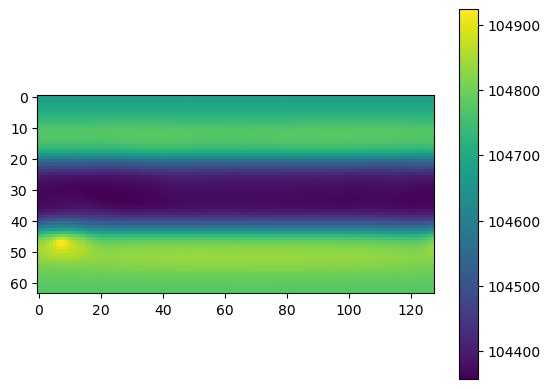

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.exp(np.squeeze(log_surface_pressure_nodal).T)*1e5)
plt.colorbar()

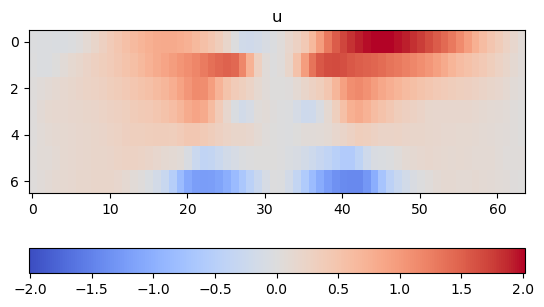

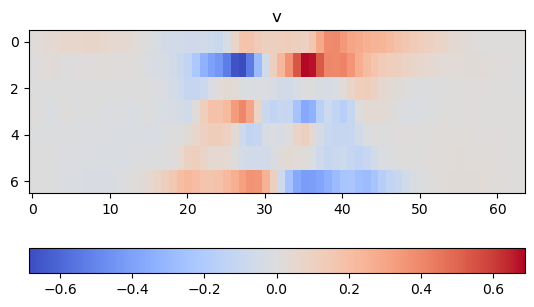

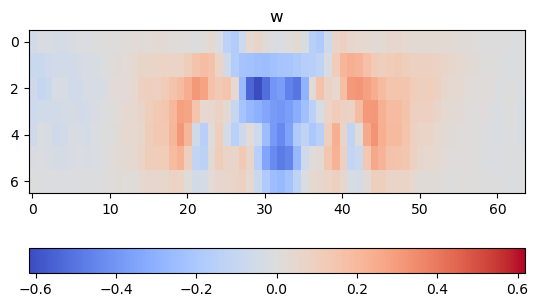

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_variable(variable, title, vmin=None, vmax=None):
    data = np.mean(variable, axis=1)
    vmin = min(np.min(data), -np.max(data)) if vmin is None else vmin
    vmax = max(np.max(data), -np.min(data)) if vmax is None else vmax
    plt.imshow(np.mean(variable, axis=1), cmap='coolwarm', vmin=vmin, vmax=vmax, aspect=3)
    plt.title(title)
    plt.colorbar(orientation='horizontal')
    plt.show()

plot_variable(u_nodal, 'u')

# norm = TwoSlopeNorm(vcenter=0)

# plt.imshow(np.mean(u_nodal, axis=1), cmap='coolwarm', norm=norm, aspect=3)
# plt.title('u')
# plt.colorbar(orientation='horizontal')
# plt.show()

plot_variable(v_nodal, 'v')

# plt.imshow(np.mean(v_nodal, axis=1), cmap='coolwarm', aspect=3)
# plt.title('v')
# plt.colorbar(orientation='horizontal')
# plt.show()

plot_variable(w_nodal, 'w')

# plt.imshow(np.mean(w_nodal, axis=1), cmap='coolwarm', aspect=3)
# plt.title('w')
# plt.colorbar(orientation='horizontal')
# plt.show()

temperature_nodal = 288 + diagnostic_final_state.temperature_variation
# plt.imshow(np.mean(temperature_nodal, axis=1), cmap='viridis', aspect=3)
# plt.title('T')
# plt.colorbar(orientation='horizontal')
# plt.show()

# plt.imshow(np.mean(diagnostic_final_state.tracers['specific_humidity'], axis=1), cmap='viridis', aspect=3)
# plt.title('q')
# plt.colorbar(orientation='horizontal')
# plt.show()

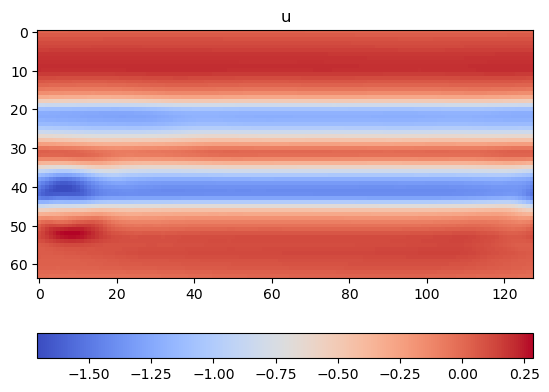

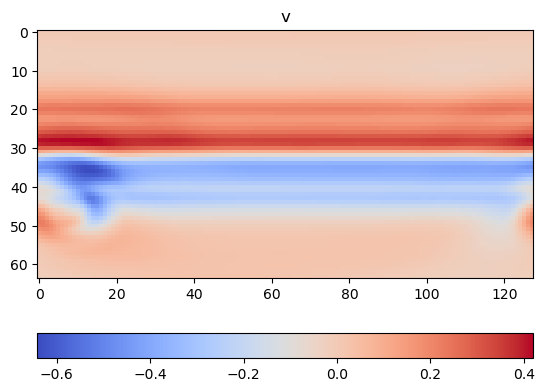

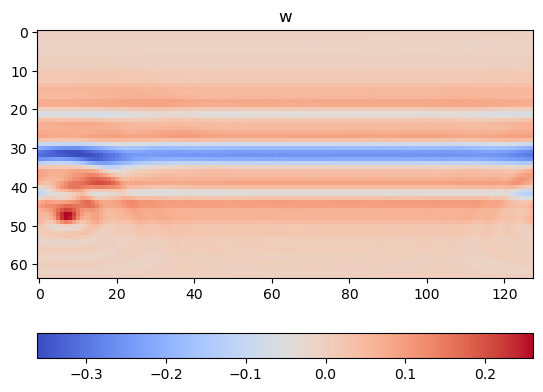

In [7]:
plt.imshow(u_nodal[-1,:,:].T, cmap='coolwarm', aspect='equal')
plt.title('u')
plt.colorbar(orientation='horizontal')
plt.show()

plt.imshow(v_nodal[-1,:,:].T, cmap='coolwarm', aspect='equal')
plt.title('v')
plt.colorbar(orientation='horizontal')
plt.show()

plt.imshow(w_nodal[-1,:,:].T, cmap='coolwarm', aspect='equal')
plt.title('w')
plt.colorbar(orientation='horizontal')
plt.show()


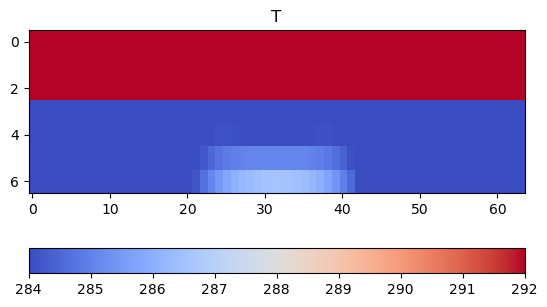

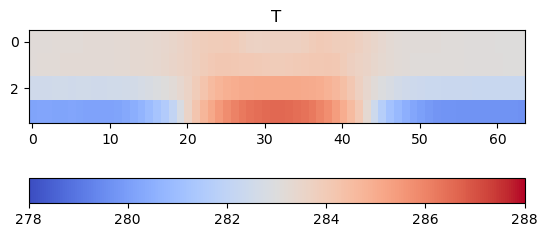

In [17]:
plot_variable(temperature_nodal, 'T', vmin=284, vmax=292)
plot_variable(temperature_nodal[3:], 'T', vmin=278, vmax=288)

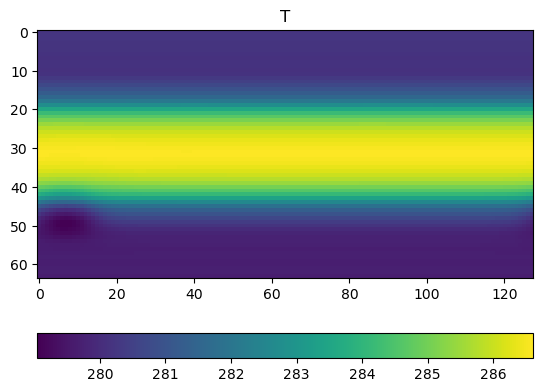

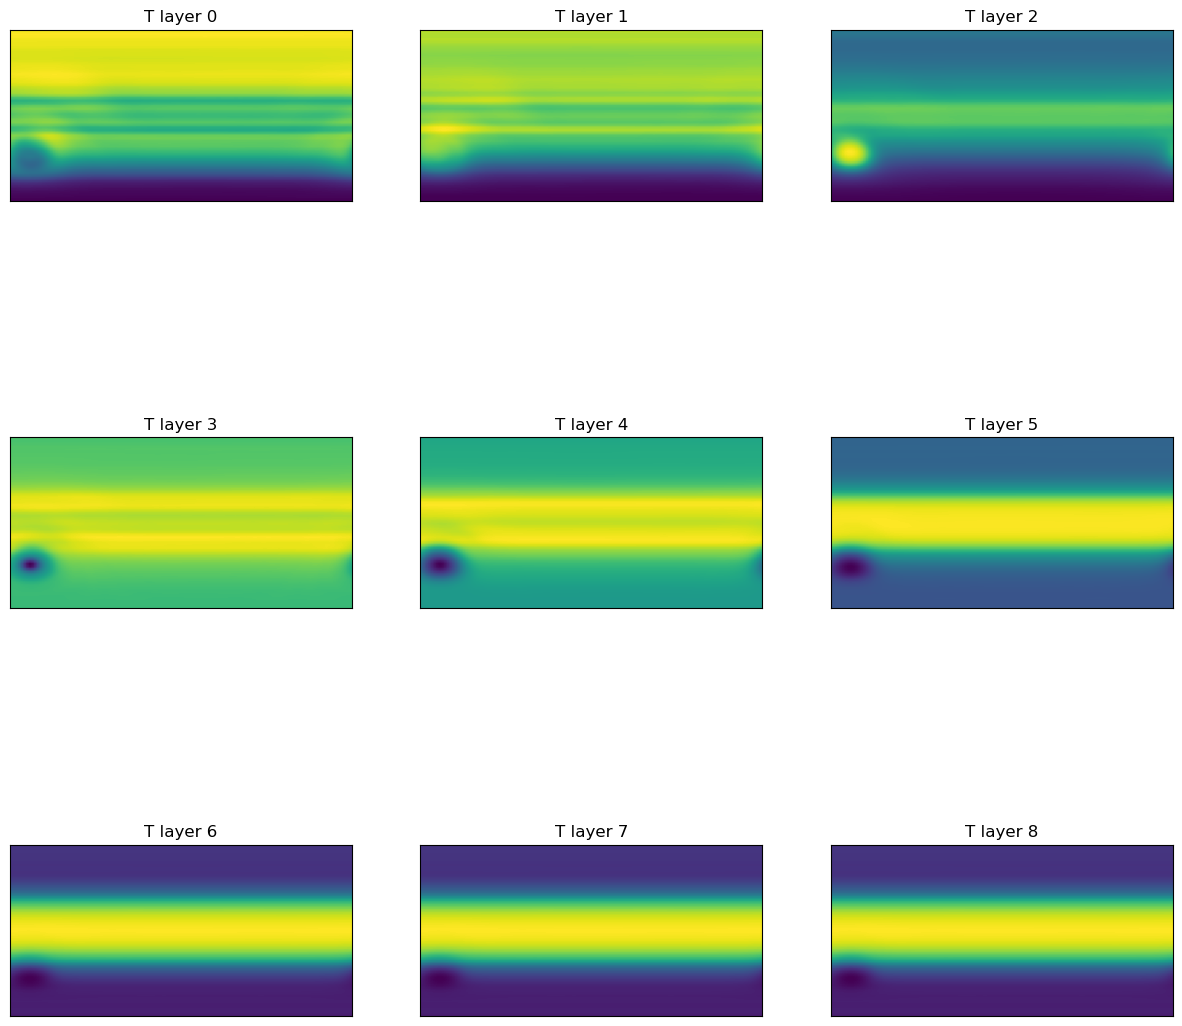

In [9]:
plt.imshow(temperature_nodal[-1,:,:].T, cmap='viridis', aspect='equal')
plt.title('T')
plt.colorbar(orientation='horizontal')
plt.show()

# make 7 subplots of the 7 layers that share a color scale
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(temperature_nodal[i,:,:].T, cmap='viridis', aspect='equal')
    ax.set_title(f'T layer {i}')
    ax.set_xticks([])
    ax.set_yticks([])

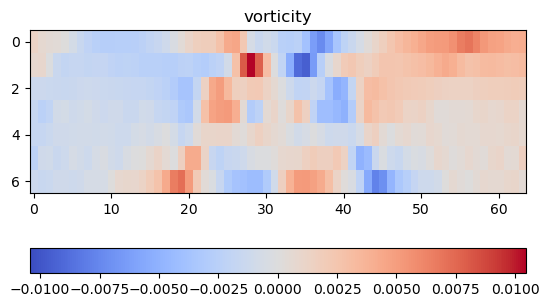

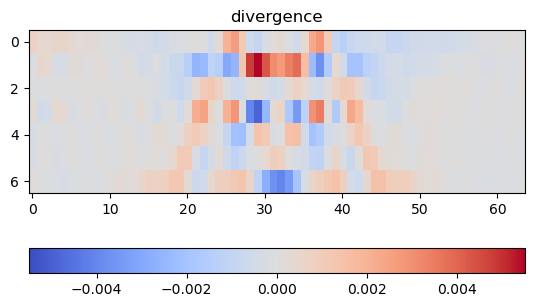

In [10]:
# plt.imshow(np.mean(diagnostic_final_state.vorticity, axis=1), cmap='coolwarm', norm=norm, aspect=3)
# plt.title('vorticity')
# plt.colorbar(orientation='horizontal')
# plt.show()

plot_variable(diagnostic_final_state.vorticity, 'vorticity')

# plt.imshow(np.mean(diagnostic_final_state.divergence, axis=1), cmap='coolwarm', norm=norm, aspect=3)
# plt.title('divergence')
# plt.colorbar(orientation='horizontal')
# plt.show()

plot_variable(diagnostic_final_state.divergence, 'divergence')